Data preprocessing :
<br>
Two data sources will be imported <br>
-"AIS_weather_h_rename_copy.csv" will be used to replace the information for true current direction and true wind direction <br>
-The resulting dataframe will be merged with the dataframe from the "AIS_weather_H_ok2_copy.csv" <br>
-The data of the journey between Ronne and Sassnitz will be omitted <br>
-The threshold for the ships manouvering speed will be 5kt (Abebe) <br>

In [214]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import pickle
import joblib

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]



In [215]:
dfpre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Time                                  7453 non-null   datetime64[ns]
 1   LON                                   7453 non-null   float64       
 2   LAT                                   7453 non-null   float64       
 3   Eastward wind                         7453 non-null   float64       
 4   Northward wind                        7453 non-null   float64       
 5   Temperature above oceans              7453 non-null   float64       
 6   Air density above oceans              7337 non-null   float64       
 7   Max wave height                       6274 non-null   float64       
 8   Swell direction                       6274 non-null   float64       
 9   Wind wave direction                   6274 non-null   float64       
 10  

In [216]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [217]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [218]:
x_pre = imputer.transform(dfpre)

In [219]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [220]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [221]:
# dfpre["True North Wind Direction"] = 180 +  np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

In [222]:
# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [223]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813,198.585961,150.634332
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934,92.310964,100.306234
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221,0.052191,0.102997
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883,139.632096,73.919853
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080,205.028650,121.289202
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129,275.302728,227.423990
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001,359.892603,359.958291


In [224]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [225]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [226]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,251.408180,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,254.458891,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,259.749663,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,266.724504,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [227]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [228]:
# Exclude data for the month of June to check the model's forecasting performance 
dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

In [229]:
# Temporary export
# df.to_csv("AIS_sog_threshold.csv")

In [230]:
# Temporary export
# df.to_csv("AIS_impute_check.csv")

Data Analysis before modelling 

In [231]:
df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)
df_ship.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
8,276.900391,1.661038,4.291309,3.667458,3.757862,279.699585,0.865413,0.323892,0.801956,5.017723,...,269.900574,91.133175,143.029898,82.454986,91.138748,90.495209,0.104064,7.648595,268.966251,52.930471
9,276.705566,1.501637,4.187211,3.145607,3.803910,279.820312,0.785675,0.452440,0.578049,5.019207,...,300.130435,68.884377,96.351303,134.548587,115.015200,120.971331,0.104050,6.700397,260.985188,36.481737
10,276.309815,1.235528,4.012717,2.120399,3.819602,NaN,0.654636,0.556525,0.236435,5.019664,...,230.117302,129.989203,174.697284,59.296837,47.905998,52.498604,0.092759,4.089472,269.893495,44.814586
11,276.399902,1.204397,4.020009,2.090308,3.820546,NaN,0.638782,0.555405,0.226181,5.019009,...,178.653615,170.879672,107.951765,8.221531,10.314571,1.236454,0.093128,3.821501,262.226057,70.701850
12,277.134033,1.275907,4.095175,3.029945,3.815268,279.820312,0.674081,0.598373,0.263031,5.020452,...,125.446296,102.327505,72.665715,47.977150,68.470208,54.270195,0.086621,5.479353,246.881208,52.780582


In [232]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [233]:
df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [234]:
# # Scaling script if necessary

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_ship2 = pd.DataFrame(scaler.fit_transform(df_ship2),columns=df_ship2.columns)


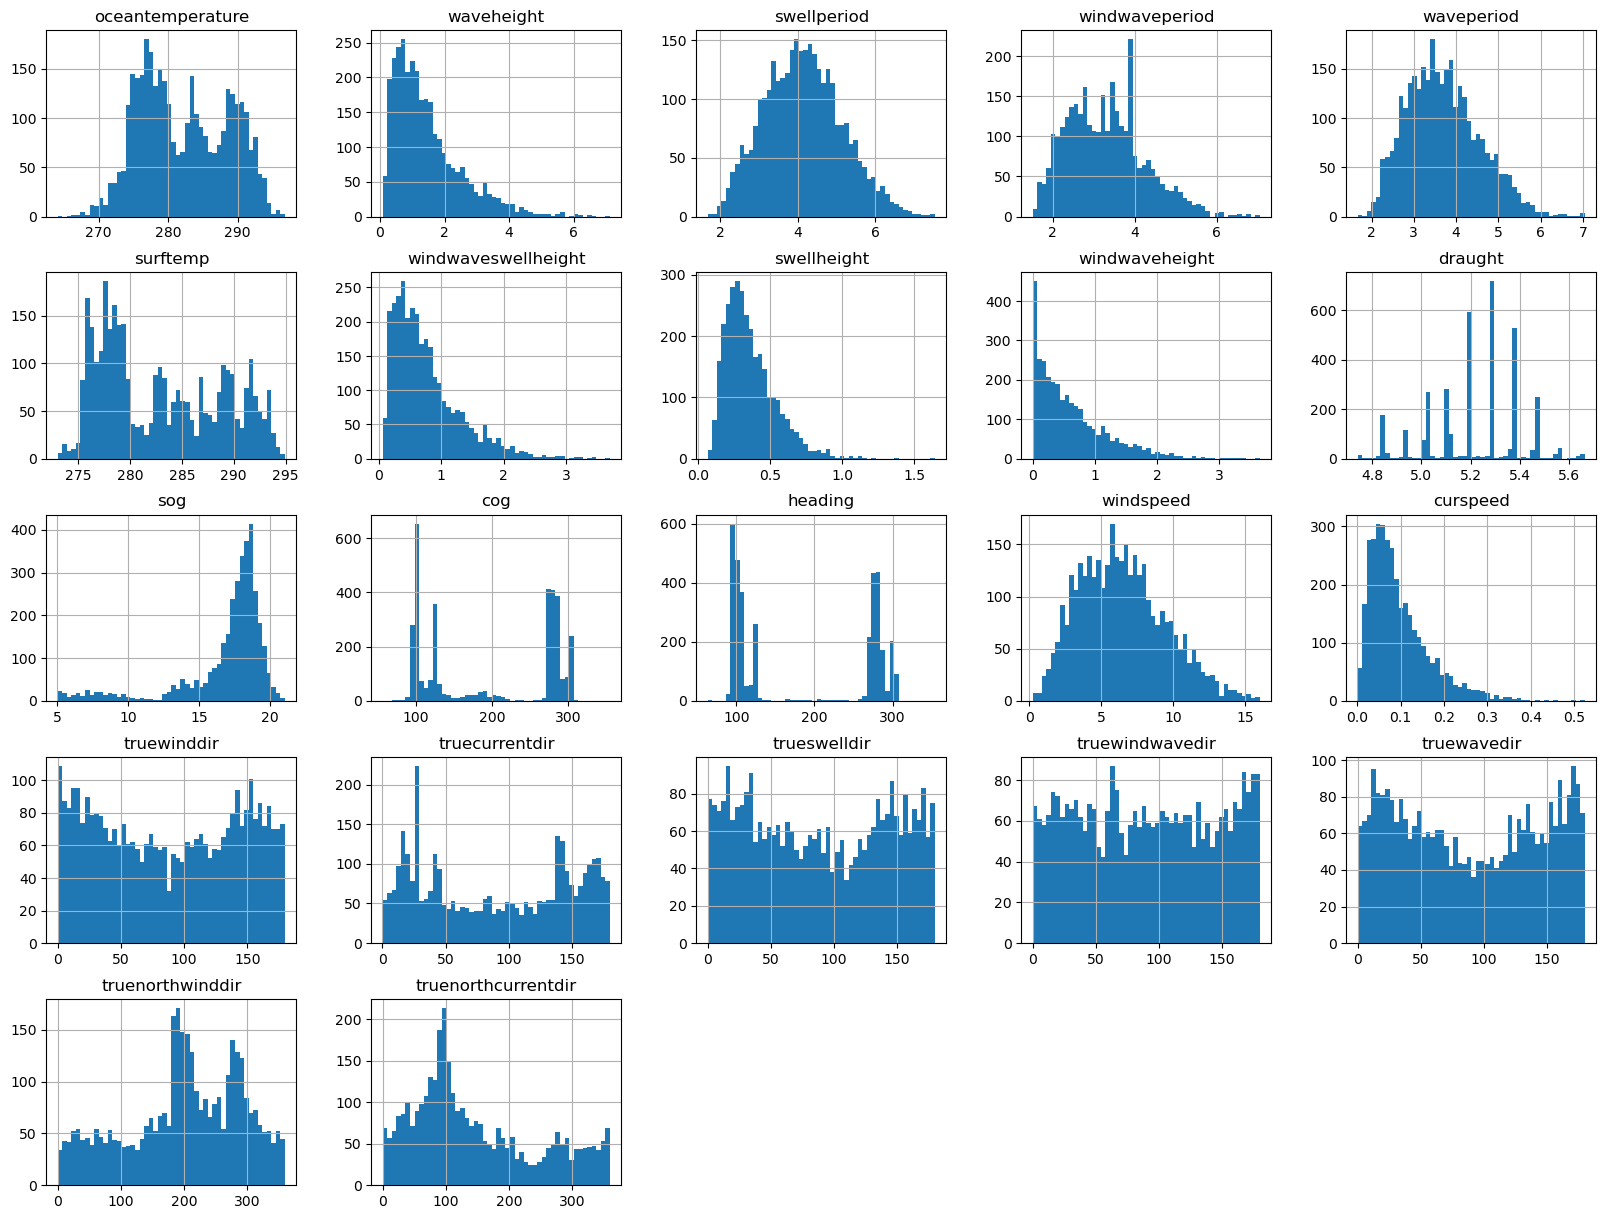

In [235]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
df_ship2.hist(bins=50,figsize=(20,15))
plt.show()

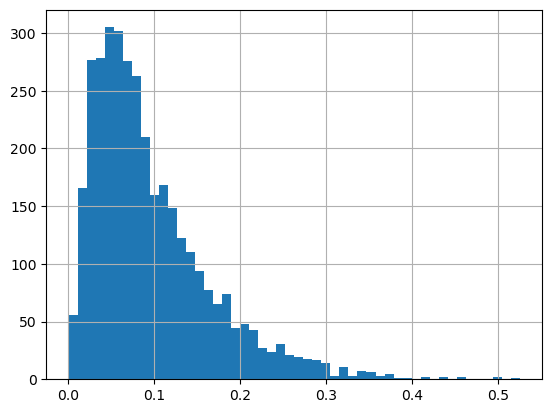

In [236]:
df_ship2['curspeed'].hist(bins=50)
plt.show()

In [237]:
hhstats = df_ship2.describe()
print(hhstats)

       oceantemperature   waveheight  swellperiod  windwaveperiod  \
count       3506.000000  3152.000000  3152.000000     3152.000000   
mean         282.187439     1.457923     4.140942        3.299684   
std            6.345629     1.052465     0.991532        0.939149   
min          264.076782     0.083379     1.681843        1.517006   
25%          276.908691     0.671875     3.416050        2.559944   
50%          281.418823     1.180761     4.102280        3.239967   
75%          288.072144     1.928374     4.810565        3.864906   
max          296.830322     7.120887     7.531564        7.052921   

        waveperiod     surftemp  windwaveswellheight  swellheight  \
count  3152.000000  3391.000000          3152.000000  3152.000000   
mean      3.698114   283.014106             0.766249     0.359745   
std       0.862321     5.765232             0.538023     0.175846   
min       1.672565   273.048584             0.065236     0.065332   
25%       3.049094   277.872803  

Feature Selection

In [238]:
corr_matrix = df_ship2.corr()
print(corr_matrix["sog"])

oceantemperature       0.066226
waveheight            -0.004305
swellperiod           -0.001119
windwaveperiod        -0.013876
waveperiod             0.002105
surftemp               0.031413
windwaveswellheight   -0.003199
swellheight           -0.020481
windwaveheight        -0.000675
draught                0.148754
sog                    1.000000
cog                    0.016333
heading                0.213539
windspeed              0.117765
curspeed               0.137821
truewinddir            0.063382
truecurrentdir         0.147950
trueswelldir           0.001415
truewindwavedir       -0.003321
truewavedir           -0.006828
truenorthwinddir      -0.022305
truenorthcurrentdir    0.106215
Name: sog, dtype: float64


In [239]:
dfship_corr = df_ship2.drop(df_ship2.columns[[0,5,15,16,17,18,19,20,21]],axis=1)
dfship_corr.head()

,waveheight,swellperiod,windwaveperiod,waveperiod,windwaveswellheight,swellheight,windwaveheight,draught,sog,cog,heading,windspeed,curspeed
8,1.661038,4.291309,3.667458,3.757862,0.865413,0.323892,0.801956,5.017723,14.578394,299.573513,269.900574,7.648595,0.104064
9,1.501637,4.187211,3.145607,3.803910,0.785675,0.452440,0.578049,5.019207,18.148696,302.274508,300.130435,6.700397,0.104050
10,1.235528,4.012717,2.120399,3.819602,0.654636,0.556525,0.236435,5.019664,9.686510,163.922318,230.117302,4.089472,0.092759
11,1.204397,4.020009,2.090308,3.820546,0.638782,0.555405,0.226181,5.019009,11.252112,117.003285,178.653615,3.821501,0.093128
12,1.275907,4.095175,3.029945,3.815268,0.674081,0.598373,0.263031,5.020452,18.119627,125.829385,125.446296,5.479353,0.086621


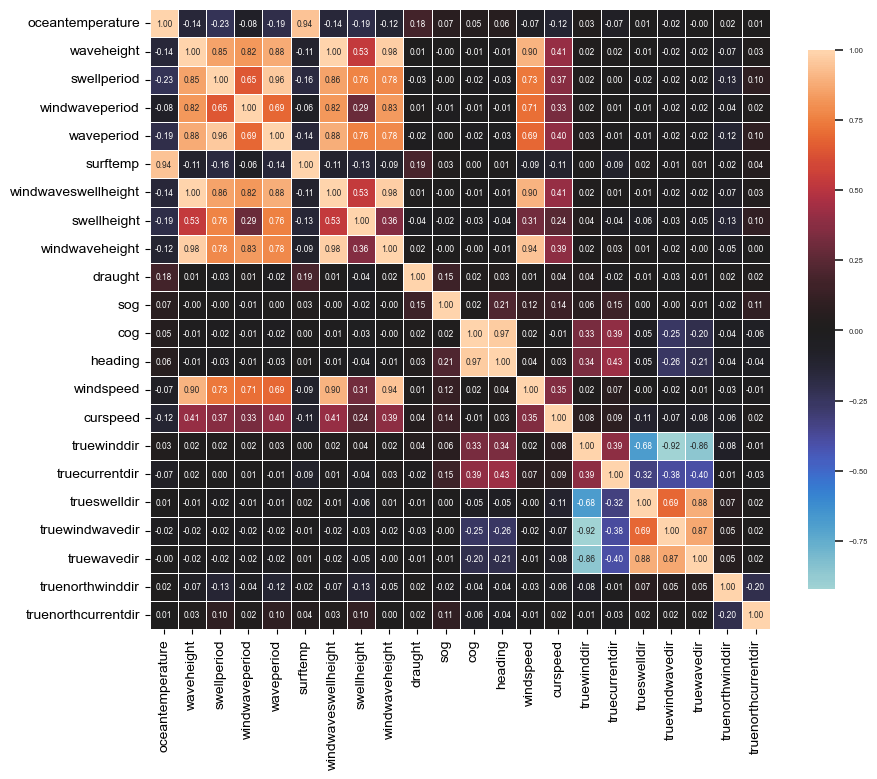

In [240]:
def correlation_heatmap(df,fontsize):
    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.set(font_scale = fontsize)
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(df_ship2,0.5)

Scientific Justification of HCF:

According to Bitner Gregersen, the wind wave swell height is equal to the square root of the square of swell wave and wind wave. Therefore SWH and WWH is to be dropped.<br>
According to Mori, through wave spectrum, the maximum wave height can be approximated, therefore max wave height can be dropped as well <br>
According to Torsetshaugen, The type of dominating wave (Wind wave/Swell) can be predicted from the significant through an equation which include the significant wave height and a certain threshold, therefore, it is decided that the wind wave period, swell period and consequently the true wind wave direction and true swell direction is to be dropped.

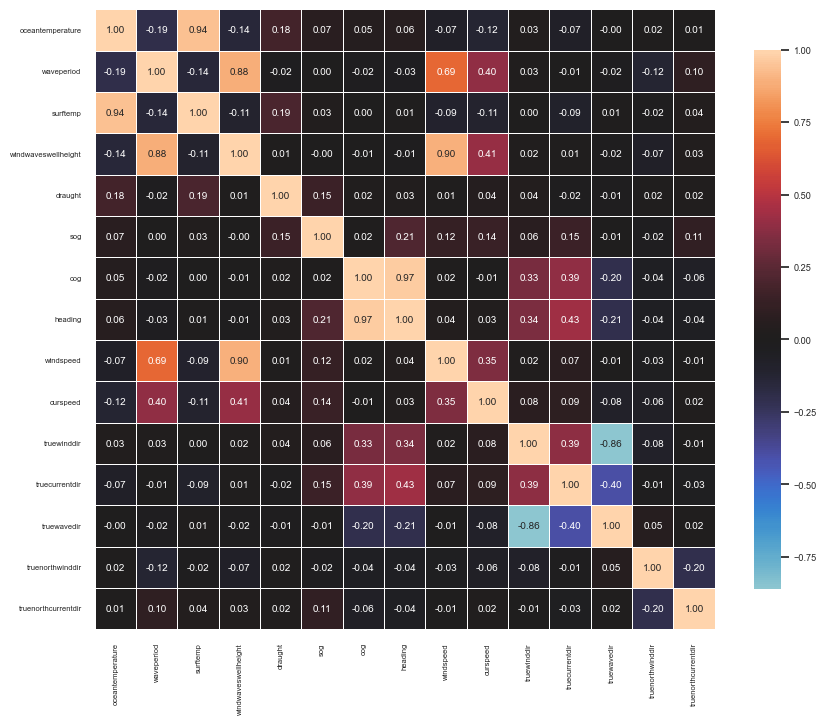

In [241]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir'],axis=1)
correlation_heatmap(df_ship2,.6)

In [242]:
# dfship_corrftf = dfship_corr.drop(['waveheight','swellheight','windwaveheight'],axis=1)

# correlation_heatmap(dfship_corrftf,1)

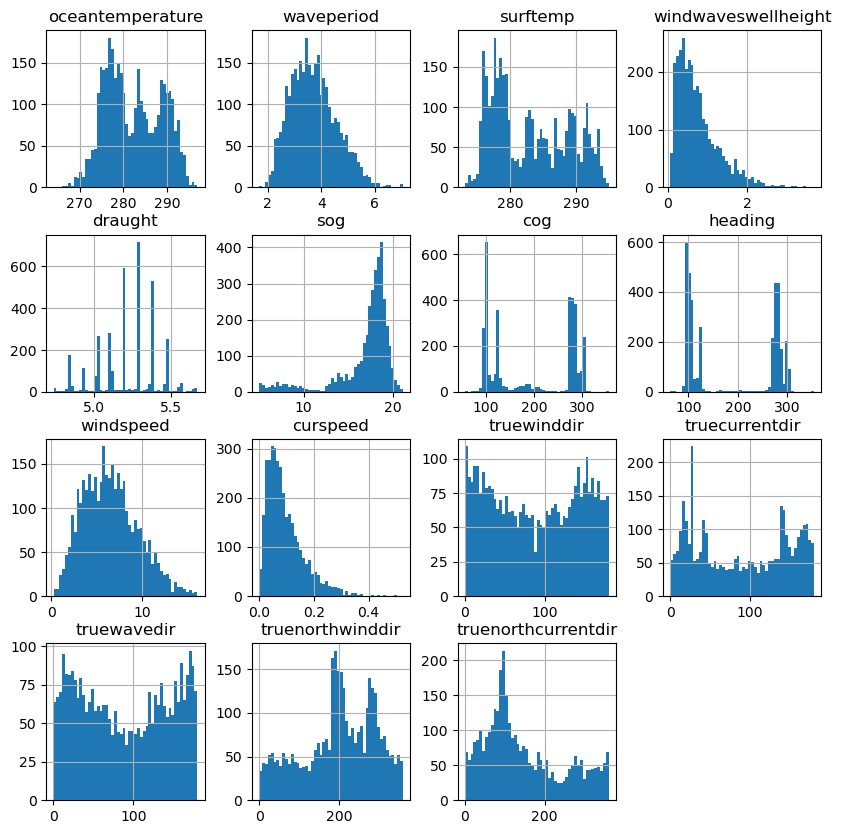

In [243]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
df_ship2.hist(bins=50,figsize=(10,10))
plt.show()

In [244]:
# from pandas.plotting import scatter_matrix

# # attributes = df_ship2.columns

# scatter_matrix(dfship_corrftf,figsize=(25,25))

In [245]:
df_ship2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     3506 non-null   float64
 1   waveperiod           3152 non-null   float64
 2   surftemp             3391 non-null   float64
 3   windwaveswellheight  3152 non-null   float64
 4   draught              3506 non-null   float64
 5   sog                  3506 non-null   float64
 6   cog                  3506 non-null   float64
 7   heading              3506 non-null   float64
 8   windspeed            3506 non-null   float64
 9   curspeed             3506 non-null   float64
 10  truewinddir          3506 non-null   float64
 11  truecurrentdir       3506 non-null   float64
 12  truewavedir          3152 non-null   float64
 13  truenorthwinddir     3506 non-null   float64
 14  truenorthcurrentdir  3506 non-null   float64
dtypes: float64(15)
memory usage: 438.2 KB


Imputing using KNN so that the Random Forest Regressor may function <br>
RFR cannot accept nan values <br>
Imputed data is then transformed

In [246]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)


KNNImputer(n_neighbors=50)

In [247]:
X = imputer.transform(df_ship2)

In [248]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [249]:
print(df_ship2tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     3506 non-null   float64
 1   waveperiod           3506 non-null   float64
 2   surftemp             3506 non-null   float64
 3   windwaveswellheight  3506 non-null   float64
 4   draught              3506 non-null   float64
 5   sog                  3506 non-null   float64
 6   cog                  3506 non-null   float64
 7   heading              3506 non-null   float64
 8   windspeed            3506 non-null   float64
 9   curspeed             3506 non-null   float64
 10  truewinddir          3506 non-null   float64
 11  truecurrentdir       3506 non-null   float64
 12  truewavedir          3506 non-null   float64
 13  truenorthwinddir     3506 non-null   float64
 14  truenorthcurrentdir  3506 non-null   float64
dtypes: float64(15)
memory usage: 438.2 KB


Data Split for training and test data

In [317]:
# Implement the Random forest, but first, data is to be split into training and validation data

from sklearn.model_selection import train_test_split

# Dropping some feature can be done here to (possibly) increase the model's performance 

# Use current and windspeed wrt to ship bow
# x_train,x_test,y_train,y_test = train_test_split(df_ship2tr.drop(['sog','truenorthcurrentdir','truenorthwinddir']
#                                                                  ,axis=1)
#                                                                 ,df_ship2tr.sog,test_size=0.2,random_state=42)

# Use True North 
x_train,x_test,y_train,y_test = train_test_split(df_ship2tr.drop(['sog','truecurrentdir','truewinddir']
                                                                 ,axis=1)
                                                                ,df_ship2tr.sog,test_size=0.2,random_state=42)


In [318]:
print("Amount of the x training dataset is:",len(x_train))

Amount of the x training dataset is: 2804


In [319]:
print("Amount of the test dataset is",len(x_test))

Amount of the test dataset is 702


Modelling using Random Forest Regressor 

In [320]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr = RandomForestRegressor(random_state=42)
model_rfr_ftr.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [321]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr_hpo = RandomForestRegressor(n_estimators=300,
                                #   max_features=9,
                                  random_state=42, 
                                  )
model_rfr_ftr_hpo.fit(x_train,y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [322]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr_hpov = RandomForestRegressor(n_estimators = 267,
                                            min_samples_split = 5,
                                            #min_samples_leaf = 2,
                                            max_features = 9,
                                            max_depth=136,
                                            bootstrap=False,
                                            random_state=42)
model_rfr_ftr_hpov.fit(x_train,y_train)

RandomForestRegressor(bootstrap=False, max_depth=136, max_features=9,
                      min_samples_split=5, n_estimators=267, random_state=42)

Modelling using ETR

In [323]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr_hpo = ExtraTreesRegressor(random_state=42,
                                n_estimators=400)
model_etr_hpo.fit(x_train,y_train)

ExtraTreesRegressor(n_estimators=400, random_state=42)

In [324]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr = ExtraTreesRegressor(random_state=42,
                                )
model_etr.fit(x_train,y_train)

ExtraTreesRegressor(random_state=42)

Modelling using Decision Tree Regressor

In [325]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
model_dtr.fit(x_train,y_train)

DecisionTreeRegressor()

Modelling using Multiple Linear Regression

In [326]:
from sklearn import linear_model
model_mlr = linear_model.LinearRegression()
model_mlr.fit(x_train,y_train)

LinearRegression()

Model Evaluation

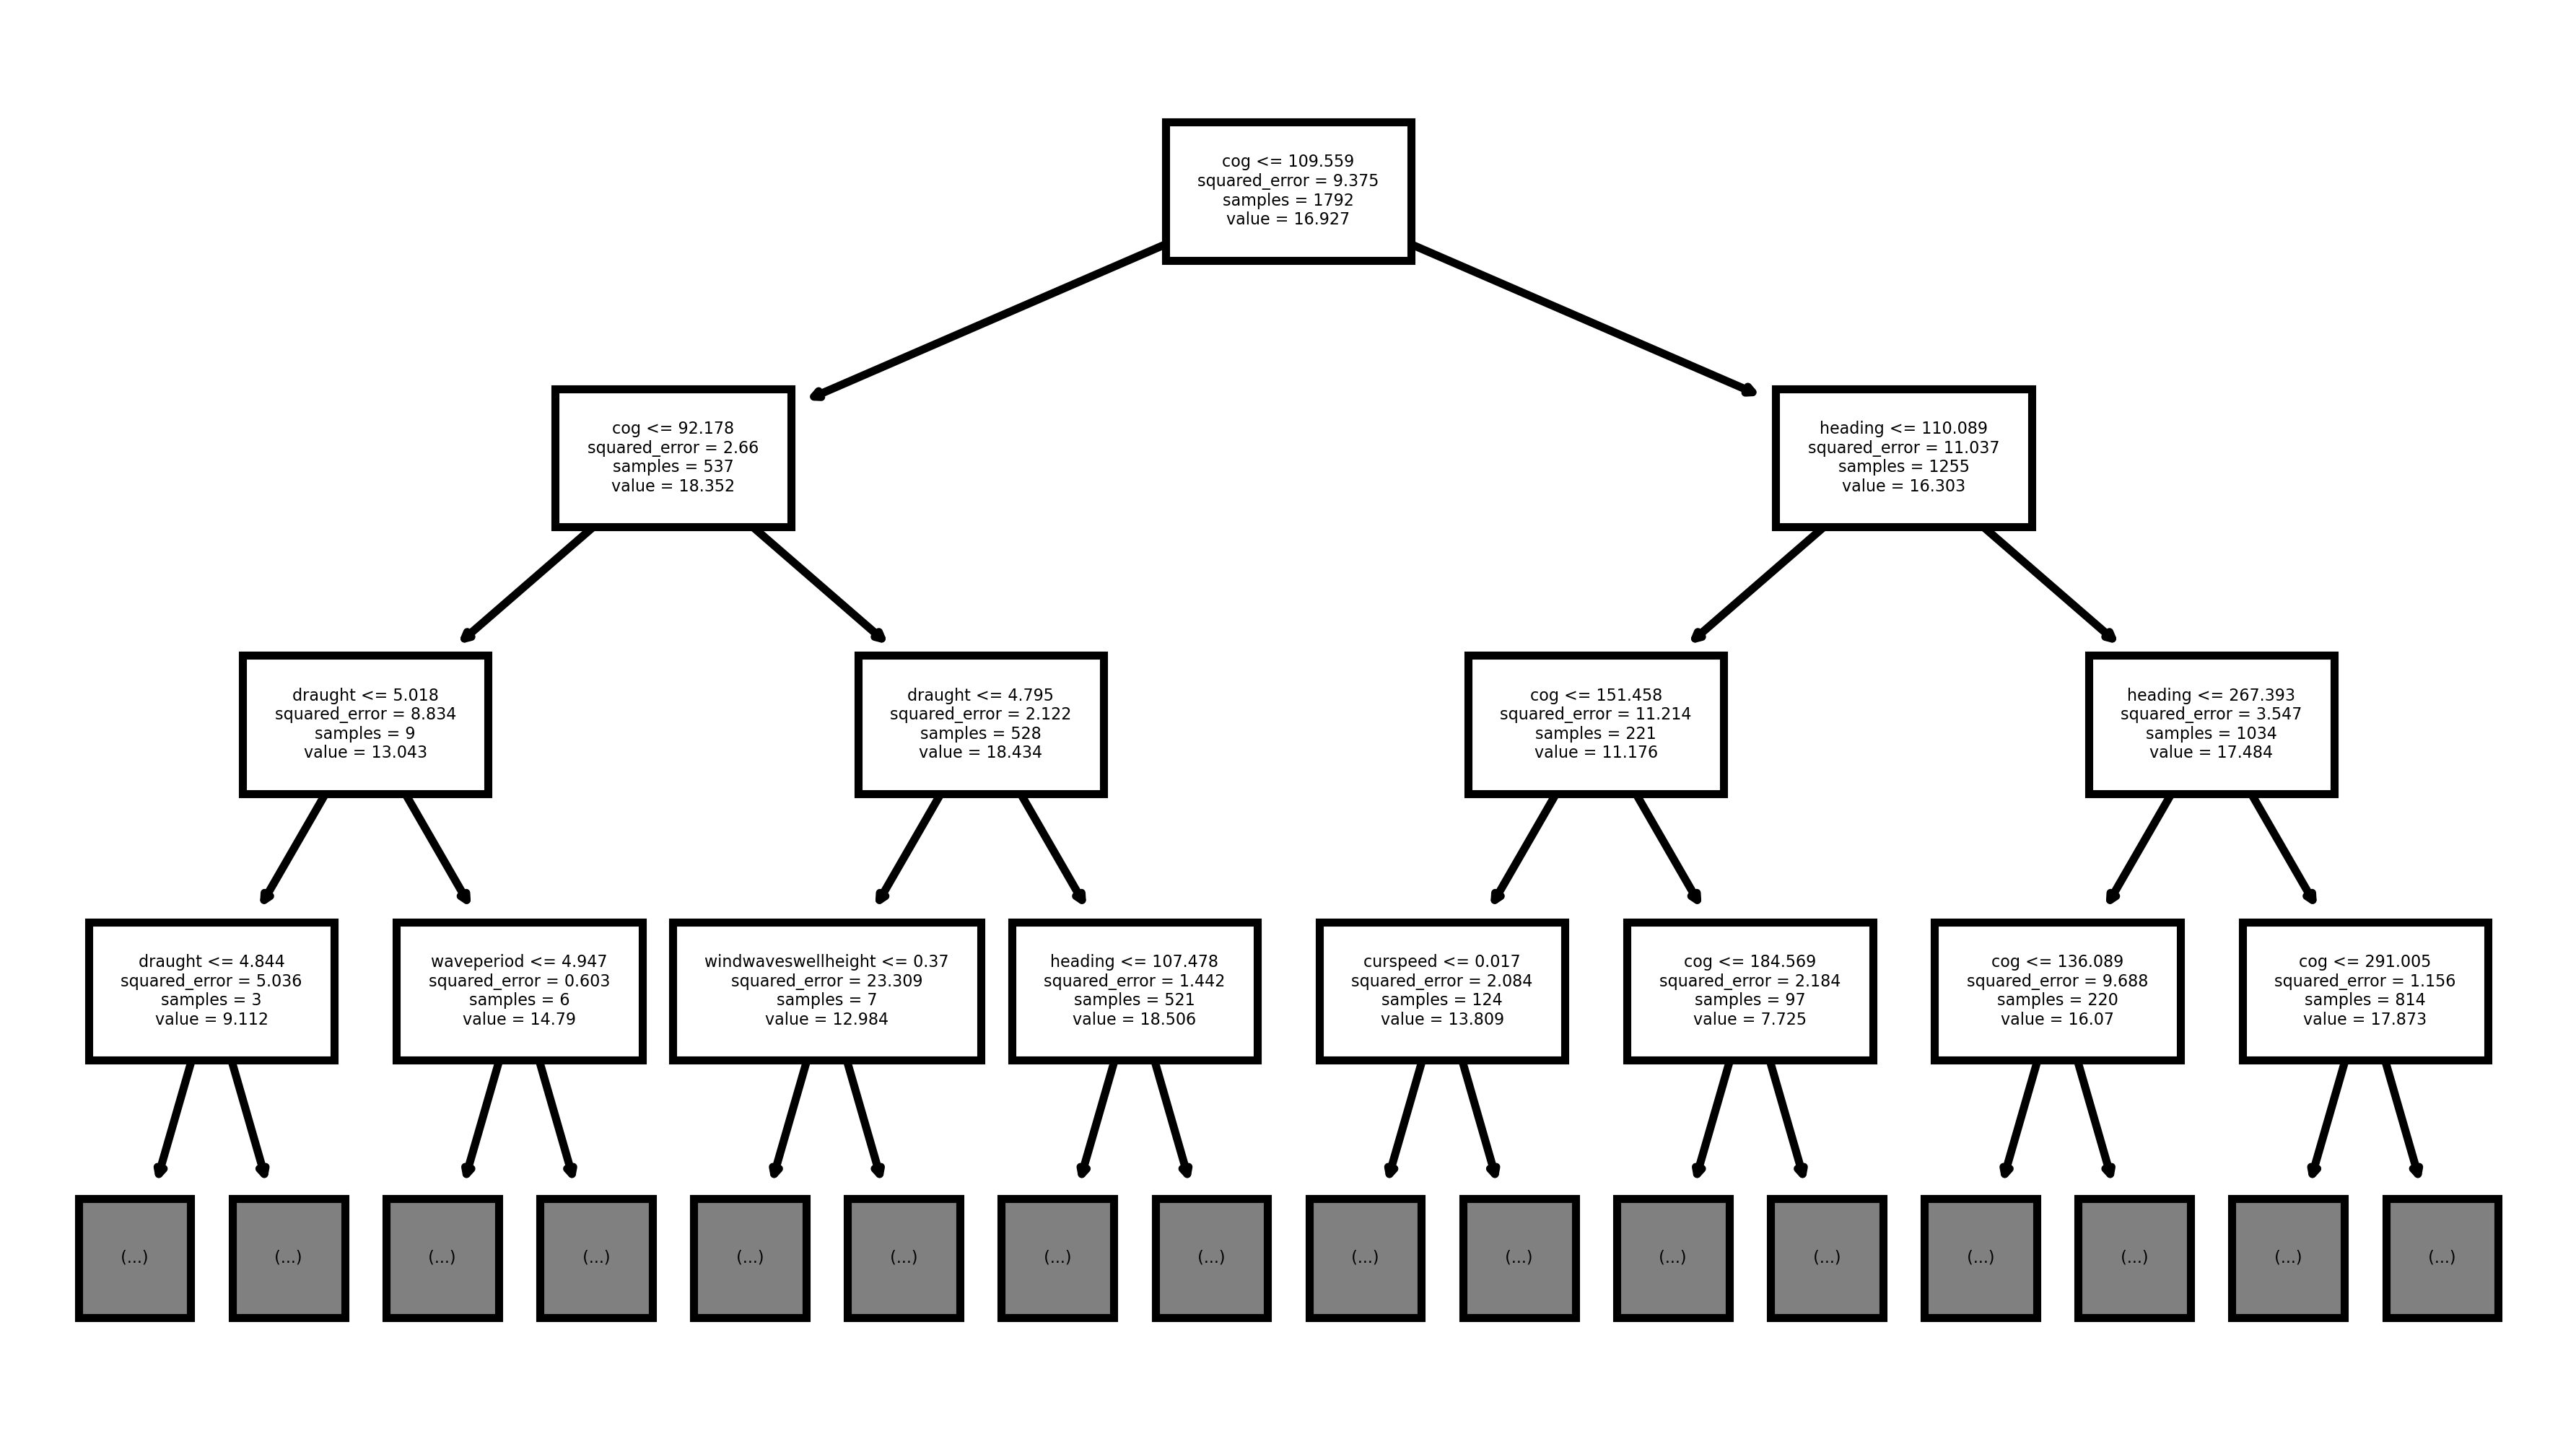

In [327]:
from sklearn import tree

def tree_visualization(width,height,model_type):
    fn=x_train.columns
    fig, axes = plt.subplots(figsize = (width,height), dpi=800)
    tree.plot_tree(model_type.estimators_[0],
               max_depth=3,
               fontsize=2,
               feature_names = fn);
    plt.show()
    #fig.savefig('rf_individualtree.png')

tree_visualization(5.5,3,model_rfr_ftr)

In [328]:
def model_importance(model_type):
    mod_imp = model_type.feature_importances_
    df_mod_imp = pd.DataFrame(mod_imp,index= x_train.columns,columns=["Importance"])
    print(df_mod_imp)

model_importance(model_rfr_ftr_hpo)

                     Importance
oceantemperature       0.005708
waveperiod             0.005711
surftemp               0.006690
windwaveswellheight    0.005674
draught                0.022430
cog                    0.457949
heading                0.461879
windspeed              0.005578
curspeed               0.007449
truewavedir            0.006153
truenorthwinddir       0.007203
truenorthcurrentdir    0.007576


Evaluation of RFR

In [329]:
def predict_y(x_test,model_type):
    y_predicted = model_type.predict(x_test)
    return y_predicted

def display_scores(x_test,y_test,model_type):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error
    y_predicted = model_type.predict(x_test)
    print("R^2 score (Indicate model fit. Best Score = 1):", model_type.score(x_test,y_test))
    print("Explained Variance EV (Indicate amount of variance in model. Best Score = 1):", explained_variance_score(y_test,y_predicted))
    print("Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0):", mean_absolute_error(y_test,y_predicted))
    print("Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0):", mean_squared_error(y_test,y_predicted))
    print("Median Absolute Error MAD (Check robustness against outlier. Best Score = 0):", median_absolute_error(y_test,y_predicted))

y_predicted = predict_y(x_test,model_rfr_ftr)
display_scores(x_test,y_test,model_rfr_ftr)


R^2 score (Indicate model fit. Best Score = 1): 0.9334942043096398
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.9335360399009582
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.5599425738331624
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 0.702407811584838
Median Absolute Error MAD (Check robustness against outlier. Best Score = 0): 0.409849388750005


Evaluation of model with FTR + HPO

In [330]:
y_predicted = predict_y(x_test,model_rfr_ftr_hpo)
display_scores(x_test,y_test,model_rfr_ftr_hpo)

R^2 score (Indicate model fit. Best Score = 1): 0.9331687267593408
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.9332141290161157
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.5553585418194914
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 0.7058453762579967
Median Absolute Error MAD (Check robustness against outlier. Best Score = 0): 0.4090906454166916


Evaluation of ETR

In [331]:
y_predicted = predict_y(x_test,model_etr)
display_scores(x_test,y_test,model_etr)

R^2 score (Indicate model fit. Best Score = 1): 0.9370477942330995
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.9371258913750482
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.5319864602019518
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 0.6648762055722046
Median Absolute Error MAD (Check robustness against outlier. Best Score = 0): 0.3851253691000043


In [332]:
y_predicted = predict_y(x_test,model_etr_hpo)
display_scores(x_test,y_test,model_etr_hpo)

R^2 score (Indicate model fit. Best Score = 1): 0.9382184890865362
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.9383275918259507
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.5294079406904816
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 0.6525117912907091
Median Absolute Error MAD (Check robustness against outlier. Best Score = 0): 0.3900919811750274


Evaluation of DTR

In [333]:
y_predicted = predict_y(x_test,model_dtr)
display_scores(x_test,y_test,model_dtr)

R^2 score (Indicate model fit. Best Score = 1): 0.838632913529132
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8389915967725488
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.8432212082792023
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.7042951053099373
Median Absolute Error MAD (Check robustness against outlier. Best Score = 0): 0.5588565549999984


In [334]:
y_predicted = predict_y(x_test,model_dtr)
display_scores(x_test,y_test,model_dtr)

R^2 score (Indicate model fit. Best Score = 1): 0.838632913529132
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8389915967725488
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.8432212082792023
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.7042951053099373
Median Absolute Error MAD (Check robustness against outlier. Best Score = 0): 0.5588565549999984


Evaluation of MLR 

In [335]:
y_predicted = predict_y(x_test,model_mlr)
display_scores(x_test,y_test,model_mlr)

R^2 score (Indicate model fit. Best Score = 1): 0.6897974542856908
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.6900963176932101
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 1.12992954400207
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 3.276236138842493
Median Absolute Error MAD (Check robustness against outlier. Best Score = 0): 0.8830015280539012


In [336]:
cdf = pd.DataFrame(model_mlr.coef_, x_test.columns, columns=['Coefficients'])
print(cdf)

                     Coefficients
oceantemperature         0.050564
waveperiod               0.433302
surftemp                -0.055959
windwaveswellheight     -0.998758
draught                  2.050362
cog                     -0.114931
heading                  0.115593
windspeed                0.102933
curspeed                -0.566315
truewavedir              0.000449
truenorthwinddir        -0.000123
truenorthcurrentdir      0.001552


Saving model to local directory

In [337]:
# Saving the model to local directory

# filename = 'savemodel_rfr_ftr.sav'
# joblib.dump(model_rfr_ftr,filename)

# filename = 'savemodel_rfr_ftr_hpo.sav'
# joblib.dump(model_rfr_ftr_hpo,filename)

# filename = 'savemodel_rfr_ftr_hpov.sav'
# joblib.dump(model_rfr_ftr_hpov,filename)

# filename = 'savemodel_etr.sav'
# joblib.dump(model_etr,filename)

# filename = 'savemodel_dtr_ftr.sav'
# joblib.dump(model_dtr,filename)

# filename = 'savemodel_mlr_ftr.sav'
# joblib.dump(model_mlr,filename)

Hyperparameter Optimization

RFR

In [338]:
# from pprint import pprint
# pprint(model_rfr_ftr.get_params())

In [339]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [100,200,300,400,500,600,700,800,900,1000]
# # Number of features to consider at every split
# # max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# # max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# # max_depth.append(None)
# # max_depth = [None]
# # Minimum number of samples required to split a node
# # min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# # min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True]# Create the random grid
# random_grid = {'n_estimators': n_estimators}
#             #    'max_features': max_features,
#             #    'max_depth': max_depth,
#             #    'min_samples_split': min_samples_split,
#             #    'min_samples_leaf': min_samples_leaf,
#             #    'bootstrap': bootstrap}
# pprint(random_grid)

In [340]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# # rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = model_rfr_ftr, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the random search model
# rf_random.fit(x_train, y_train)

In [341]:
# rf_random.best_params_

In [342]:
# def evaluate(model, test_features, test_labels):
#     from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

#     predictions = model.predict(test_features)
#     rsquared = model.score(test_features,test_labels)
#     expVar = explained_variance_score(test_labels,predictions)
#     MAE = mean_absolute_error(test_labels,predictions)
#     MAD = median_absolute_error(test_labels,predictions)
#     RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

#     print(f"Model Performance of {model}")
#     print(f"R^2: {rsquared:0.4f}")
#     print(f"explained Variance = {expVar:0.4f}")
#     print(f"MAE = {MAE:0.4f}")
#     print(f"RMSE = {RMSE:0.4f}")
#     print(f"MAD = {MAD:0.4f}\n")
    
#     return rsquared,expVar,MAE,RMSE,MAD

# base_model = model_rfr_ftr
# base_model.fit(x_train, y_train)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_test, y_test)

# best_random = rf_random.best_estimator_
# rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_test, y_test)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

ETR HPO


In [343]:
# from pprint import pprint
# pprint(model_etr.get_params())

In [344]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [100,200,300,400,500,600,700,800,900,1000]

# # n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# # Number of features to consider at every split
# # max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# # max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# # max_depth.append(None)
# max_depth = [None]
# # Minimum number of samples required to split a node
# # min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# # min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# # bootstrap = [True]# Create the random grid
# random_grid = {'n_estimators': n_estimators}
#                #'max_features': max_features,
#                #'max_depth': max_depth,
#                #'min_samples_split': min_samples_split,
#                #'min_samples_leaf': min_samples_leaf,
#                #'bootstrap': bootstrap}
# pprint(random_grid)

In [345]:
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = model_etr, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=1,n_jobs=-1)# Fit the random search model
# rf_random.fit(x_train, y_train)

In [346]:
# rf_random.best_params_

In [347]:
# def evaluate(model, test_features, test_labels):
#     from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

#     predictions = model.predict(test_features)
#     rsquared = model.score(test_features,test_labels)
#     expVar = explained_variance_score(test_labels,predictions)
#     MAE = mean_absolute_error(test_labels,predictions)
#     MAD = median_absolute_error(test_labels,predictions)
#     RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

#     print(f"Model Performance of {model}")
#     print(f"R^2: {rsquared:0.4f}")
#     print(f"explained Variance = {expVar:0.4f}")
#     print(f"MAE = {MAE:0.4f}")
#     print(f"RMSE = {RMSE:0.4f}")
#     print(f"MAD = {MAD:0.4f}\n")
    
#     return rsquared,expVar,MAE,RMSE,MAD

# base_model = model_etr
# base_model.fit(x_train, y_train)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_test, y_test)

# best_random = rf_random.best_estimator_
# rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_test, y_test)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

DTR

In [348]:
# # Number of trees in random forest
# # Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# max_depth.append(None)
# # max_depth = [None]
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# random_grid_dtr = {'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,}
# pprint(random_grid_dtr)

In [349]:
# dt_random = RandomizedSearchCV(estimator = model_dtr, param_distributions = random_grid_dtr, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the dt search model
# dt_random.fit(x_train, y_train)

In [350]:
# dt_random.best_params_

In [351]:
# base_model = model_dtr
# base_model.fit(x_train, y_train)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_test, y_test)

# best_random = dt_random.best_estimator_
# rsquared_random,expVar_random,MAE_random,RMSE_base,MAD_random = evaluate(best_random, x_test, y_test)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

In [352]:
# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
#     print('Model Performance')
#     print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
    
#     return accuracy

# base_model = model_rfr_ftr
# base_model.fit(x_test, y_test)
# base_accuracy = evaluate(base_model, x_test, y_test)
# best_random = rf_random.best_estimator_
# random_accuracy = evaluate(best_random, x_test, y_test)
# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [353]:
# from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 230, stop = 240, num = 10)]
# # Number of features to consider at every split
# max_features = [9]
# # Maximum number of levels in tree
# max_depth = [None]
# # Minimum number of samples required to split a node
# min_samples_split = [2]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1]
# # Method of selecting samples for training each tree
# bootstrap = [True]# Create the random grid
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# pprint(param_grid)
# # Create a based model

# grid_search = GridSearchCV(estimator = model_rfr_ftr, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

Use GridSearch

In [354]:
# # Fit the grid search to the data
# grid_search.fit(x_train, y_train)
# grid_search.best_params_

In [355]:
# best_grid = grid_search.best_estimator_
# grid_accuracy = evaluate(best_grid, x_test, y_test)

In [356]:
# print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Forecasting for June 2021

In [357]:
# dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
# 'Surface pressure','Width','Length'],axis=1)
# dfdate6.head(n=5)

In [358]:
# dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
#                            'SOG': 'sog', 'Wind Speed': 'windspeed', 
#                            'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
#                            'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
#                             'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
#                             'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
#                             'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
#                             'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
#                             'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
#                            }, axis=1) 

In [359]:
# import numpy as np
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=50)

In [360]:
# dfdate6 = dfdate6[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]


In [361]:
# imputer.fit(dfdate6)

In [362]:
# xdate = imputer.transform(dfdate6)

In [363]:
# dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [364]:
# x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
# y_date = dfdate6tr.sog

In [365]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 21)]
# # Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# # max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# # max_depth.append(None)
# max_depth = [None]
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True]# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# pprint(random_grid)

In [366]:
# rf_random = RandomizedSearchCV(estimator = model_rfr_ftr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the random search model
# rf_random.fit(x_train, y_train)

In [367]:
# rf_random.best_params_

In [368]:
# def evaluate(model, test_features, test_labels):
#     from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

#     predictions = model.predict(test_features)
#     rsquared = model.score(test_features,test_labels)
#     expVar = explained_variance_score(test_labels,predictions)
#     MAE = mean_absolute_error(test_labels,predictions)
#     MAD = median_absolute_error(test_labels,predictions)
#     RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

#     print(f"Model Performance of {model}")
#     print(f"R^2: {rsquared:0.4f}")
#     print(f"explained Variance = {expVar:0.4f}")
#     print(f"MAE = {MAE:0.4f}")
#     print(f"RMSE = {RMSE:0.4f}")
#     print(f"MAD = {MAD:0.4f}\n")
    
#     return rsquared,expVar,MAE,RMSE,MAD

# base_model = model_rfr_ftr
# base_model.fit(x_train, y_train)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_date, y_date)

# # best_random = rf_random.best_estimator_
# best_random = model_rfr_ftr_hpov
# rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_date, y_date)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

In [369]:
# import numpy as np
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=50)

In [370]:
# imputer.fit(dfdate6)

In [371]:
# xdate = imputer.transform(dfdate6)

In [372]:
# dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [373]:
# x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
# y_date = dfdate6tr.sog

In [374]:
# y_predicted = predict_y(x_date,model_rfr)
# display_scores(x_date,y_date,model_rfr)


In [375]:
# display_scores(x_date,y_date,model_dtr)


In [376]:
# ydate_pred = y_predicted
# dfprog_sog = pd.Series(y_date,name="sog_act").to_frame()
# dfprog_sog["sog_pred"] = ydate_pred
# dfprog_sog["gamma"] = dfdate6tr["truenorthcurrentdir"]
# dfprog_sog["truenorthwinddir"] = dfdate6tr["truenorthwinddir"]

# print(dfprog_sog)

In [377]:
# dfprog = pd.concat([x_date,dfprog_sog],axis=1)
# dfprog.head(n=10)

In [378]:
# dfprog["vgms"] = dfprog["sog_pred"]/1.9438

In [379]:
# rad_gamma = np.deg2rad(dfprog["gamma"])
# rad_cog = np.deg2rad(dfprog["cog"])

In [380]:
# dfprog["vgx"] = dfprog["vgms"] * np.sin(rad_cog)
# dfprog["vcx"] = dfprog["curspeed"] * np.sin(rad_gamma)
# dfprog["stw_x"] = (dfprog["vgx"] - dfprog["vcx"])

In [381]:
# dfprog["vgy"] = dfprog["vgms"] * np.cos(rad_cog)
# dfprog["vcy"] = dfprog["curspeed"] * np.cos(rad_gamma)
# dfprog["stw_y"] = (dfprog["vgy"] - dfprog["vcy"])

In [382]:
# dfprog["vwms_p"] = np.sqrt(dfprog["stw_x"]**2 + dfprog["stw_y"]**2)
# dfprog["stw_pred"] = dfprog["vwms_p"]*1.9438
# dfprog = dfprog.drop(['vgms','vgx','vcx','stw_x',
#                       'vgy','vcy','stw_y',
#                       'vwms_p'],axis=1)
# #df_ship.head(n=5)
# dfprog.head(n=10)

In [383]:
# dfprog.describe()